In [ ]:
import pandas as pd  #for dataframes
import numpy as np
from tqdm.notebook import tqdm  #to visualize execution
from sklearn.model_selection import train_test_split   #to divide dataset in train and test
from sklearn.feature_extraction.text import TfidfVectorizer  #to vectorize txt
from sklearn.pipeline import Pipeline  #to make pipeline
from sklearn.metrics import mean_absolute_error  #for metric of our model
import pickle  #for saving models
import re  #for regular expression
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor  #algo for regression
RS=42  #we will fix random state

In [ ]:
# подключаем гугл диск на котором данные
from google.colab import drive
drive.mount ('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/'My Drive'/dataset_trud/

model_trud01.pickle  model_trud05_cb.pickle		vacs_train.csv
model_trud02.pickle  tokenize_text_simple_regex.pickle	описание-2.xlsx


In [ ]:
df_salaries100k = pd.read_csv('../content/gdrive/My Drive/dataset_trud/vacs_train.csv',index_col='index',sep=';')
df_salaries100k.head(20)


,id,name,name.lemm,area.name,city,company.id,company,company_link,publication_date,salary_from,salary_currency,employment,employment.name,schedule,schedule.name,experience,experience.name,key_skills,specializations,specializations.names,description,description.lemm,type
index,,,,,,,,,,,,,,,,,,,,,,,
0,17686451,Менеджер по туризму,менеджер туризм,Санкт-Петербург,Санкт-Петербург,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-08-21T14:52:35+0300,40000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,17.334 17.242 17.149 22.223 22.39 22.199,Продажи - Услуги для населения | Продажи - Пря...,Обязанности: Работа с туристами (физические и...,обязанность работа турист физический юридическ...,train
1,17840390,Помощник руководителя,помощник руководитель,Санкт-Петербург,unknown,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-08-21T14:28:29+0300,40000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,4.205 4.429 6.319 6.247 2.249,Административный персонал - Персональный ассис...,Вакансия открыта в рамках отдела строительно-о...,вакансия открывать рамка отдел строительный от...,train
3,17665840,Аналитик,аналитик,Санкт-Петербург,unknown,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-08-19T11:57:57+0300,30000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,1.117 1.327 1.25,"Информационные технологии, интернет, телеком -...",Обязанности: Работа в рамках отдела корпорати...,обязанность работа рамка отдел корпоративный п...,train
4,17914658,Авиакассир,авиакассир,Санкт-Петербург,Санкт-Петербург,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-07-29T16:17:47+0300,30000.0,RUR,full,Полная занятость,shift,Сменный график,between1And3,От 1 года до 3 лет,NaN,22.11 21.12 17.334,"Туризм, гостиницы, рестораны - Авиабилеты | Тр...",Обязанности: Бронирование и выписка авиабилет...,обязанность бронирование выписка авиабилет сис...,train
5,17665632,Бухгалтер,бухгалтер,Санкт-Петербург,Санкт-Петербург,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-07-18T15:39:05+0300,25000.0,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,NaN,2.43 2.335 2.463 2.337 2.469 5.42,"Бухгалтерия, управленческий учет, финансы пред...",Обязанности: Ведение бухгалтерского и налогов...,обязанность ведение бухгалтерский налоговый уч...,train
6,17118641,Web-программист,Web программист,Санкт-Петербург,Санкт-Петербург,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-06-15T11:46:59+0300,45000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,1.221 1.273 1.420 1.9 1.10,"Информационные технологии, интернет, телеком -...",Обязанности: разработка сайтов компании; инте...,обязанность разработка сайт компания интеграци...,train
7,16795167,Бухгалтер,бухгалтер,Санкт-Петербург,Санкт-Петербург,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-06-03T11:05:46+0300,25000.0,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,NaN,2.43 2.335 2.463 2.337 2.469 5.42,"Бухгалтерия, управленческий учет, финансы пред...",Обязанности: Ведение бухгалтерского и налогов...,обязанность ведение бухгалтерский налоговый уч...,train
8,17274713,Менеджер по туризму,менеджер туризм,Санкт-Петербург,Санкт-Петербург,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-06-02T14:30:41+0300,30000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,22.223 22.39 22.199 17.242 17.149,"Туризм, гостиницы, рестораны - Продажа туристи...",Обязанности: прием заявок от корпоративных кл...,обязанность прием заявка корпоративный клиент ...,train
9,17257258,Прораб отделочных работ,прораб отделочный работа,Санкт-Петербург,unknown,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-06-01T11:58:44+0300,40000.0,RUR,full,Полная занятость,flexible,Гибкий график,between3And6,От 3 до 6 лет,Ответственность | Коммуникабельность,20.287 20.

In [ ]:
df_salaries100k.shape

(100001, 23)

In [ ]:
df_salaries100k.describe()

,id,company.id,salary_from
count,1.000010e+05,1.000010e+05,100001.000000
mean,2.029259e+07,1.066682e+06,41048.389456
std,2.733736e+06,9.670595e+05,21801.077872
min,4.140466e+06,6.000000e+00,15.000000
25%,1.771999e+07,8.305600e+04,28750.000000
50%,2.005649e+07,9.111140e+05,35000.000000
75%,2.369521e+07,1.880360e+06,50000.000000
max,2.433712e+07,3.553214e+06,400000.000000


In [ ]:
df_salaries100k.columns

Index(['id', 'name', 'name.lemm', 'area.name', 'city', 'company.id', 'company',
       'company_link', 'publication_date', 'salary_from', 'salary_currency',
       'employment', 'employment.name', 'schedule', 'schedule.name',
       'experience', 'experience.name', 'key_skills', 'specializations',
       'specializations.names', 'description', 'description.lemm', 'type'],
      dtype='object')

In [ ]:
#сделаем колонку lemms в которой объединим данные из name.lemm и description.lemm это должно существеннго повысить
#точность предсказания
df_salaries100k['lemms']=df_salaries100k['name.lemm']+' '+df_salaries100k['description.lemm']
df_salaries100k.head()


,id,name,name.lemm,area.name,city,company.id,company,company_link,publication_date,salary_from,salary_currency,employment,employment.name,schedule,schedule.name,experience,experience.name,key_skills,specializations,specializations.names,description,description.lemm,type,lemms
index,,,,,,,,,,,,,,,,,,,,,,,,
0,17686451,Менеджер по туризму,менеджер туризм,Санкт-Петербург,Санкт-Петербург,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-08-21T14:52:35+0300,40000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,17.334 17.242 17.149 22.223 22.39 22.199,Продажи - Услуги для населения | Продажи - Пря...,Обязанности: Работа с туристами (физические и...,обязанность работа турист физический юридическ...,train,менеджер туризм обязанность работа турист физи...
1,17840390,Помощник руководителя,помощник руководитель,Санкт-Петербург,unknown,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-08-21T14:28:29+0300,40000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,4.205 4.429 6.319 6.247 2.249,Административный персонал - Персональный ассис...,Вакансия открыта в рамках отдела строительно-о...,вакансия открывать рамка отдел строительный от...,train,помощник руководитель вакансия открывать рамка...
3,17665840,Аналитик,аналитик,Санкт-Петербург,unknown,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-08-19T11:57:57+0300,30000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,1.117 1.327 1.25,"Информационные технологии, интернет, телеком -...",Обязанности: Работа в рамках отдела корпорати...,обязанность работа рамка отдел корпоративный п...,train,аналитик обязанность работа рамка отдел корпор...
4,17914658,Авиакассир,авиакассир,Санкт-Петербург,Санкт-Петербург,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-07-29T16:17:47+0300,30000.0,RUR,full,Полная занятость,shift,Сменный график,between1And3,От 1 года до 3 лет,NaN,22.11 21.12 17.334,"Туризм, гостиницы, рестораны - Авиабилеты | Тр...",Обязанности: Бронирование и выписка авиабилет...,обязанность бронирование выписка авиабилет сис...,train,авиакассир обязанность бронирование выписка ав...
5,17665632,Бухгалтер,бухгалтер,Санкт-Петербург,Санкт-Петербург,605490,"007, центр услуг",https://hh.ru/employer/605490,2016-07-18T15:39:05+0300,25000.0,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,NaN,2.43 2.335 2.463 2.337 2.469 5.42,"Бухгалтерия, управленческий учет, финансы пред...",Обязанности: Ведение бухгалтерского и налогов...,обязанность ведение бухгалтерский налоговый уч...,train,бухгалтер обязанность ведение бухгалтерский на...


In [ ]:
#посморим сколько у нас валют
df_salaries100k['salary_currency'].nunique()

1

хорошая новость, зарплаты у нас все в рублях. заморачиваться по переводу зарплат в других валютах нет.

In [ ]:
#посморим сколько у нас работодателей
df_salaries100k['company.id'].nunique()

17513

In [ ]:
df_salaries100k['company.id'].value_counts()

533        1855
1111042    1501
232489     1082
1419273     895
1942330     873
           ... 
1918967       1
1128377       1
2070445       1
2858924       1
2785997       1
Name: company.id, Length: 17513, dtype: int64

In [ ]:
#сделакм классификатор на основе Берт, который будет определять работодателя по вакансии
#для начал возьмет топ3 работодателя и будет определять их


In [ ]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 4.8MB/s 
     |████████████████████████████████| 890kB 15.5MB/s 
     |████████████████████████████████| 1.1MB 30.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e8b49912f6b8ca50605e8860f267aa38aa8f705ea047043797003b786de4c486
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import io
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [ ]:
def add_CLS_SEP(txt):
  """
  This func add [CLS] AT THE BEGINNING OF TEXT AND [SEP] AT THE END OF TEXT
  БЕРТу нужет такой формат
  """
  txt=str(txt).lower()
  txt = "[CLS] " + txt[:500] + " [SEP]"
  return txt

In [ ]:
#проверяем функцию выше
add_CLS_SEP('Мама мыла, раму и')

'[CLS] мама мыла, раму и [SEP]'

In [ ]:
#выберем из датасета три самых популярных работодателя
set_top3_employers={533,1111042,232489}

In [ ]:
#take lines for top spec
df_salaries=df_salaries100k.loc[df_salaries100k['company.id'].isin(set_top3_employers)]
df_salaries.head()

,id,name,name.lemm,area.name,city,company.id,company,company_link,publication_date,salary_from,salary_currency,employment,employment.name,schedule,schedule.name,experience,experience.name,key_skills,specializations,specializations.names,description,description.lemm,type,lemms
index,,,,,,,,,,,,,,,,,,,,,,,,
13513,16830052,Менеджер по продажам электротехнической продукции,менеджер продажа электротехнический продукция,Санкт-Петербург,Санкт-Петербург,232489,АРЕС,https://hh.ru/employer/232489,2017-06-05T15:41:57+0300,80000.0,RUR,full,Полная занятость,fullDay,Полный день,noExperience,Нет опыта,NaN,17.397 17.417 17.358 17.279 17.152,"Продажи - Электротехническое оборудование, Све...",Обязанности: ведение и расширение клиентской...,обязанность ведение расширение клиентский база...,train,менеджер продажа электротехнический продукция ...
13514,13705065,Менеджер по продвижению индустриальных ЛКМ,менеджер продвижение индустриальный ЛКМ,Санкт-Петербург,Санкт-Петербург,232489,АРЕС,https://hh.ru/employer/232489,2017-05-22T17:54:28+0300,60000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,18.348 17.401 17.417 17.196 17.149 17.279,Производство - Химическая промышленность | Про...,Производство ЛКМ приглашает менеджера по продв...,производство ЛКМ приглашать менеджер продвижен...,train,менеджер продвижение индустриальный ЛКМ произв...
13515,17475725,Менеджер по продвижению эпоксидных наливных полов,менеджер продвижение эпоксидный наливной пол,Санкт-Петербург,unknown,232489,АРЕС,https://hh.ru/employer/232489,2017-05-22T17:54:28+0300,60000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,17.401 17.417 17.196 17.149,Продажи - Химическая продукция | Продажи - Стр...,Производство ЛКМ приглашает менеджера по продв...,производство ЛКМ приглашать менеджер продвижен...,train,менеджер продвижение эпоксидный наливной пол п...
13517,17289192,Электромонтажник-сборщик щитового оборудования...,электромонтажник сборщик щитовой оборудование ГРЩ,Санкт-Петербург,Санкт-Петербург,232489,АРЕС,https://hh.ru/employer/232489,2017-01-23T15:42:52+0300,40000.0,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,29.560 29.515 29.581 18.360,"Рабочий персонал - Электромонтер, Кабельщик | ...",Обязанности: сборка низковольтного электрощи...,обязанность сборка низковольтный электрощитово...,train,электромонтажник сборщик щитовой оборудование ...
13519,17148803,Электромонтажник,электромонтажник,Санкт-Петербург,unknown,232489,АРЕС,https://hh.ru/employer/232489,2016-12-26T15:09:31+0300,60000.0,RUR,project,Проектная работа,fullDay,Полный день,between3And6,От 3 до 6 лет,NaN,29.560 29.515 29.581 20.387,"Рабочий персонал - Электромонтер, Кабельщик | ...",Крупная электротехническая компания приглашает...,крупный электротехнический компания приглашать...,train,электромонтажник крупный электротехнический ко...


In [ ]:
df_salaries.shape

(4438, 24)

In [ ]:
sentences=[add_CLS_SEP(x) for x in list(df_salaries['lemms'])]  #make txt
print(sentences[1])

[CLS] менеджер продвижение индустриальный лкм производство лкм приглашать менеджер продвижение индустриальный лакокрасочный материал требование опыт продажа аналогичный продукция обязанность поиск клиент работа проектный организация конечный заказчик координация исполнение проект работа исполнитель условие месторасположение ладожский график работа оплата зависимость результат работа [SEP]


In [ ]:
len(sentences)

4438

In [ ]:
df_y=df_salaries['company.id']
df_y.head()

index
13513    232489
13514    232489
13515    232489
13517    232489
13519    232489
Name: company.id, dtype: int64

In [ ]:
le = LabelEncoder()
df_y=le.fit_transform(df_y)
#le.inverse_transform(y_pred)
df_y

array([1, 1, 1, ..., 2, 2, 2])

In [ ]:
set_y=set(df_y)
print(set_y)

{0, 1, 2}


In [ ]:
#make onehot encoding for emploers
#from sklearn.preprocessing import OneHotEncoder
#y=pd.get_dummies(df_salaries['company.id'])
#=df_salaries['company.id']
#y.head()

In [ ]:
#DIVIDE DATA TO TRAIN AND TEST
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, 
                                                                      df_y, 
                                                                      test_size=0.5,random_state=RS)

In [ ]:
#создадим датафрейм в который запишем резушльтат работы алгоритма на тесте(валидация)
len(train_gt)

2219

In [ ]:
df_test=pd.DataFrame(np.random.rand(2219,1),columns=['random'])
df_test.head()

,random
0,0.710972
1,0.490861
2,0.592231
3,0.199814
4,0.892183


In [ ]:
df_test['sentenses']= test_sentences
df_test.head()

,random,sentenses
0,0.710972,[CLS] модельер конструктор обязанность констру...
1,0.490861,[CLS] оператор call центр должностной обязанно...
2,0.592231,[CLS] ведущий менеджер тендер крупный компания...
3,0.199814,[CLS] продавец мобильный техника приморский пр...
4,0.892183,[CLS] работник торговый зал должностной обязан...


In [ ]:
df_test['y_encoded']= test_gt
df_test.head()

,random,sentenses,y_encoded
0,0.710972,[CLS] модельер конструктор обязанность констру...,2
1,0.490861,[CLS] оператор call центр должностной обязанно...,2
2,0.592231,[CLS] ведущий менеджер тендер крупный компания...,1
3,0.199814,[CLS] продавец мобильный техника приморский пр...,0
4,0.892183,[CLS] работник торговый зал должностной обязан...,0


In [ ]:
from pytorch_transformers import BertTokenizer, BertConfig
#МЫ ИСПОЛЬЗУЕМ bert-uncased что значит что он заточен под работу со словами в нижнем регистре
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 855988.10B/s]


['[CLS]', 'ш', '##в', '##е', '##и', '##ц', '##а', '##р', 'о', '##б', '##я', '##з', '##ан', '##н', '##о', '##с', '##т', '##ь', 'в', '##с', '##т', '##р', '##е', '##ч', '##а', 'г', '##о', '##с', '##т', '##ь', 'в', '##х', '##о', '##д', 'г', '##о', '##с', '##т', '##и', '##н', '##и', '##ц', '##а', 'п', '##о', '##м', '##о', '##щ', '##ь', 'б', '##а', '##г', '##а', '##ж', 'с', '##о', '##п', '##р', '##ов', '##о', '##ж', '##д', '##е', '##н', '##и', '##е', 'г', '##о', '##с', '##т', '##ь', 'т', '##а', '##к', '##с', '##и', 'т', '##р', '##е', '##б', '##ов', '##ан', '##и', '##е', 'к', '##о', '##м', '##м', '##у', '##н', '##и', '##ка', '##б', '##е', '##л', '##ь', '##н', '##о', '##с', '##т', '##ь', 'д', '##о', '##б', '##р', '##о', '##ж', '##е', '##л', '##а', '##т', '##е', '##л', '##ь', '##н', '##о', '##с', '##т', '##ь', 'в', '##е', '##ж', '##л', '##и', '##в', '##о', '##с', '##т', '##ь', 'о', '##т', '##в', '##е', '##т', '##с', '##т', '##в', '##е', '##н', '##н', '##ы', '##и', 'о', '##т', '##н', '##о', '##ш

BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
%%time
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

CPU times: user 668 ms, sys: 34 µs, total: 668 ms
Wall time: 667 ms


In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=RS,
    test_size=0.2
)

In [ ]:
train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=RS,
    test_size=0.2
)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_labels

tensor([2, 0, 2,  ..., 2, 2, 2])

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [ ]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.cuda()

100%|██████████| 440473133/440473133 [00:12<00:00, 35068112.54B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

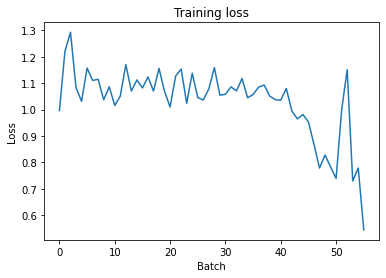

Loss на обучающей выборке: 1.03207
CPU times: user 19.7 s, sys: 6.19 s, total: 25.8 s
Wall time: 26 s


In [ ]:
%%time
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()
#device='cpu'

for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    #print('TRAIN LOSS : ',loss[0].item())
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


In [ ]:
# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    #batch_labels = np.concatenate(label_ids)   
    batch_labels = label_ids  
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 68.47%


In [ ]:
# Оценка качества на отложенной выборке

tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)  

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [ ]:
%%time
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    #batch_labels = np.concatenate(label_ids)  
    batch_labels = label_ids
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

CPU times: user 4.51 s, sys: 2.57 s, total: 7.08 s
Wall time: 7.08 s


In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 69.76%


In [ ]:
df_test['pred']=test_preds
df_test.head()

,random,sentenses,y_encoded,pred
0,0.710972,[CLS] модельер конструктор обязанность констру...,2,2
1,0.490861,[CLS] оператор call центр должностной обязанно...,2,2
2,0.592231,[CLS] ведущий менеджер тендер крупный компания...,1,2
3,0.199814,[CLS] продавец мобильный техника приморский пр...,0,0
4,0.892183,[CLS] работник торговый зал должностной обязан...,0,0


In [ ]:
df_test['decoded_preds']=list(le.inverse_transform(test_preds))
df_test.head()

,random,sentenses,y_encoded,pred,decoded_preds
0,0.710972,[CLS] модельер конструктор обязанность констру...,2,2,2
1,0.490861,[CLS] оператор call центр должностной обязанно...,2,2,2
2,0.592231,[CLS] ведущий менеджер тендер крупный компания...,1,2,2
3,0.199814,[CLS] продавец мобильный техника приморский пр...,0,0,0
4,0.892183,[CLS] работник торговый зал должностной обязан...,0,0,0


In [ ]:
#регулярное выражение с помощью которого будет токенизировать колонку description
TOKEN_RE = re.compile(r'[\w\d]+')  #regular expression to start with

In [ ]:
def tokenize_text_simple_regex(txt, min_token_size=4):
    """ This func tokenize text with TOKEN_RE applied ealier """
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

In [ ]:
#divide dataset to train and test

X_train, X_val, y_train, y_val=train_test_split(df_salaries100k['lemms'],\
                                                df_salaries100k['salary_from'], test_size=0.6,random_state=RS)

In [ ]:
sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=0.97,
                                                      min_df=3)),
                             #('cls', RandomForestRegressor(n_estimators=100,max_depth=30,n_jobs=-1, \
                             #                     verbose=True,random_state=RS))),
                             ('cls', LGBMRegressor(random_state=RS,max_depth=200,
                                                       num_leaves=300,
                                                       min_data_in_leaf=100,
                                                       n_estimators=300))),
                            verbose=True)

In [ ]:
sklearn_pipeline.fit(X_train,y_train);

[Pipeline] .............. (step 1 of 2) Processing vect, total=   3.6s
[Pipeline] ............... (step 2 of 2) Processing cls, total= 4.6min


In [ ]:
print('Скор на трейне',sklearn_pipeline.score(X_train, y_train))
print('Скор по валидации',sklearn_pipeline.score(X_val, y_val))

Скор на трейне 0.9414916188945684
Скор по валидации 0.587854161314989


In [ ]:
#let s make prediction
prediction = sklearn_pipeline.predict(X_val[-1:])
print(X_val[-1:])
print(prediction)
err = mean_absolute_error(prediction, y_val.iloc[-1:])
print(err)

index
70489    продавец консультант купчино тц балканский обя...
Name: lemms, dtype: object
[25877.1026182]
122.89738180026688


In [ ]:
#let s see error on train and validation
print('Error on train is ',mean_absolute_error(sklearn_pipeline.predict(X_train),y_train))
print('Error on validation is ',mean_absolute_error(sklearn_pipeline.predict(X_val),y_val))

Error on train is  2585.84207220461
Error on validation is  8482.362312336618


In [ ]:
#загружаем тесторые данные
df_salaries_test = pd.read_csv('../content/gdrive/My Drive/dataset_trud/vacs_test.csv',index_col='index',sep=';')
df_salaries_test.head(20)


,id,name,name.lemm,area.name,city,company.id,company,company_link,publication_date,salary_from,salary_currency,employment,employment.name,schedule,schedule.name,experience,experience.name,key_skills,specializations,specializations.names,description,description.lemm,type
index,,,,,,,,,,,,,,,,,,,,,,,
150869,24030837,Бухгалтер на участок Банковские операции,бухгалтер участок банковский операция,Санкт-Петербург,unknown,1449838,Управляющая компания Технологии Тепличного Роста,https://hh.ru/employer/1449838,2018-01-15T13:54:19+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,5.45 5.42 5.250,"Банки, инвестиции, лизинг - Валютный контроль ...","В Управляющей компании ""Технологии Тепличного ...",управляющий компания технология тепличный рост...,test
150870,24012268,Помощник бухгалтера,помощник бухгалтер,Санкт-Петербург,Санкт-Петербург,1449838,Управляющая компания Технологии Тепличного Роста,https://hh.ru/employer/1449838,2018-01-09T16:22:00+0300,NaN,RUR,full,Полная занятость,flexible,Гибкий график,noExperience,Нет опыта,NaN,2.179 2.469 15.730,"Бухгалтерия, управленческий учет, финансы пред...","В управляющей компании ""Технологии Тепличного ...",управляющий компания технология тепличный рост...,test
150871,23707419,Заместитель главного бухгалтера,заместитель главный бухгалтер,Санкт-Петербург,Санкт-Петербург,1449838,Управляющая компания Технологии Тепличного Роста,https://hh.ru/employer/1449838,2017-12-13T16:45:16+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,NaN,2.43 2.261 2.249,"Бухгалтерия, управленческий учет, финансы пред...","В Управляющей компании ""Технологии Тепличного ...",управляющий компания технология тепличный рост...,test
150872,24306509,Торговый представитель по продажам КГС (компре...,торговый представитель продажа КГС компрессор ...,Санкт-Петербург,unknown,964064,Управляющая компания Техстройконтракт,https://hh.ru/employer/964064,2018-02-27T10:50:04+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,Активная жизненная позиция | Коммуникабельност...,7.14 7.222 17.15 17.242 17.306,Автомобильный бизнес - Автозапчасти | Автомоби...,"Обязанности: Продажа компрессоров, генераторо...",обязанность продажа компрессор генератор сварк...,test
150873,24043072,Заместитель директора по сервису,заместитель директор сервис,Санкт-Петербург,unknown,964064,Управляющая компания Техстройконтракт,https://hh.ru/employer/964064,2018-02-13T09:34:20+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,NaN,7.267 7.14 7.222 17.15 26.407,Автомобильный бизнес - Сервисное обслуживание ...,Обязанности: Продажа услуг по сервисному обсл...,обязанность продажа услуга сервисный обслужива...,test
150874,24075774,Торговый представитель по продажам дорожно-стр...,торговый представитель продажа дорожно-строите...,Санкт-Петербург,unknown,964064,Управляющая компания Техстройконтракт,https://hh.ru/employer/964064,2018-01-12T16:28:02+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,Прямые продажи | Ведение переговоров | Активны...,17.59 17.15 17.242 17.306 17.279 7.222,"Продажи - ГСМ, нефть, бензин | Продажи - Автом...",Обязанности: Продажа импортной дорожно-строит...,обязанность продажа импортный дорожно-строител...,test
150875,24053466,Менеджер по продажам сервисных услуг,менеджер продажа сервисный услуга,Санкт-Петербург,unknown,964064,Управляющая компания Техстройконтракт,https://hh.ru/employer/964064,2018-01-11T14:48:40+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,Пользователь ПК | Грамотная речь | Поиск инфор...,7.267 7.14 7.222 17.15 25.385 26.407,Автомобильный бизнес - Сервисное обслуживание ...,Обязанности: Продажа услуг по сервисному обсл...,обязанность продажа услуга сервисный обслужива...,test
150876,24043013,Слесарь-механик,слесарь механик,Санкт-Петербург,unknown,964064,Управляющая компания Техстройконтракт,https://hh.ru/employer/96406

In [ ]:
#сделаем колонку lemms в которой объединим данные из name.lemm и description.lemm это должно существеннго повысить
#точность предсказания
df_salaries_test['lemms']=df_salaries_test['name.lemm']+' '+df_salaries_test['description.lemm']
df_salaries_test.head()

,id,name,name.lemm,area.name,city,company.id,company,company_link,publication_date,salary_from,salary_currency,employment,employment.name,schedule,schedule.name,experience,experience.name,key_skills,specializations,specializations.names,description,description.lemm,type,lemms
index,,,,,,,,,,,,,,,,,,,,,,,,
150869,24030837,Бухгалтер на участок Банковские операции,бухгалтер участок банковский операция,Санкт-Петербург,unknown,1449838,Управляющая компания Технологии Тепличного Роста,https://hh.ru/employer/1449838,2018-01-15T13:54:19+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,5.45 5.42 5.250,"Банки, инвестиции, лизинг - Валютный контроль ...","В Управляющей компании ""Технологии Тепличного ...",управляющий компания технология тепличный рост...,test,бухгалтер участок банковский операция управляю...
150870,24012268,Помощник бухгалтера,помощник бухгалтер,Санкт-Петербург,Санкт-Петербург,1449838,Управляющая компания Технологии Тепличного Роста,https://hh.ru/employer/1449838,2018-01-09T16:22:00+0300,NaN,RUR,full,Полная занятость,flexible,Гибкий график,noExperience,Нет опыта,NaN,2.179 2.469 15.730,"Бухгалтерия, управленческий учет, финансы пред...","В управляющей компании ""Технологии Тепличного ...",управляющий компания технология тепличный рост...,test,помощник бухгалтер управляющий компания технол...
150871,23707419,Заместитель главного бухгалтера,заместитель главный бухгалтер,Санкт-Петербург,Санкт-Петербург,1449838,Управляющая компания Технологии Тепличного Роста,https://hh.ru/employer/1449838,2017-12-13T16:45:16+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,NaN,2.43 2.261 2.249,"Бухгалтерия, управленческий учет, финансы пред...","В Управляющей компании ""Технологии Тепличного ...",управляющий компания технология тепличный рост...,test,заместитель главный бухгалтер управляющий комп...
150872,24306509,Торговый представитель по продажам КГС (компре...,торговый представитель продажа КГС компрессор ...,Санкт-Петербург,unknown,964064,Управляющая компания Техстройконтракт,https://hh.ru/employer/964064,2018-02-27T10:50:04+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,Активная жизненная позиция | Коммуникабельност...,7.14 7.222 17.15 17.242 17.306,Автомобильный бизнес - Автозапчасти | Автомоби...,"Обязанности: Продажа компрессоров, генераторо...",обязанность продажа компрессор генератор сварк...,test,торговый представитель продажа КГС компрессор ...
150873,24043072,Заместитель директора по сервису,заместитель директор сервис,Санкт-Петербург,unknown,964064,Управляющая компания Техстройконтракт,https://hh.ru/employer/964064,2018-02-13T09:34:20+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,NaN,7.267 7.14 7.222 17.15 26.407,Автомобильный бизнес - Сервисное обслуживание ...,Обязанности: Продажа услуг по сервисному обсл...,обязанность продажа услуга сервисный обслужива...,test,заместитель директор сервис обязанность продаж...


In [ ]:
prediction_test = sklearn_pipeline.predict(df_salaries_test['lemms'])

In [ ]:
df_salaries_test['salary_pred']=prediction_test
df_salaries_test.head()

,id,name,name.lemm,area.name,city,company.id,company,company_link,publication_date,salary_from,salary_currency,employment,employment.name,schedule,schedule.name,experience,experience.name,key_skills,specializations,specializations.names,description,description.lemm,type,lemms,salary_pred
index,,,,,,,,,,,,,,,,,,,,,,,,,
150869,24030837,Бухгалтер на участок Банковские операции,бухгалтер участок банковский операция,Санкт-Петербург,unknown,1449838,Управляющая компания Технологии Тепличного Роста,https://hh.ru/employer/1449838,2018-01-15T13:54:19+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,NaN,5.45 5.42 5.250,"Банки, инвестиции, лизинг - Валютный контроль ...","В Управляющей компании ""Технологии Тепличного ...",управляющий компания технология тепличный рост...,test,бухгалтер участок банковский операция управляю...,37984.603388
150870,24012268,Помощник бухгалтера,помощник бухгалтер,Санкт-Петербург,Санкт-Петербург,1449838,Управляющая компания Технологии Тепличного Роста,https://hh.ru/employer/1449838,2018-01-09T16:22:00+0300,NaN,RUR,full,Полная занятость,flexible,Гибкий график,noExperience,Нет опыта,NaN,2.179 2.469 15.730,"Бухгалтерия, управленческий учет, финансы пред...","В управляющей компании ""Технологии Тепличного ...",управляющий компания технология тепличный рост...,test,помощник бухгалтер управляющий компания технол...,24855.983145
150871,23707419,Заместитель главного бухгалтера,заместитель главный бухгалтер,Санкт-Петербург,Санкт-Петербург,1449838,Управляющая компания Технологии Тепличного Роста,https://hh.ru/employer/1449838,2017-12-13T16:45:16+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,NaN,2.43 2.261 2.249,"Бухгалтерия, управленческий учет, финансы пред...","В Управляющей компании ""Технологии Тепличного ...",управляющий компания технология тепличный рост...,test,заместитель главный бухгалтер управляющий комп...,58691.055573
150872,24306509,Торговый представитель по продажам КГС (компре...,торговый представитель продажа КГС компрессор ...,Санкт-Петербург,unknown,964064,Управляющая компания Техстройконтракт,https://hh.ru/employer/964064,2018-02-27T10:50:04+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,Активная жизненная позиция | Коммуникабельност...,7.14 7.222 17.15 17.242 17.306,Автомобильный бизнес - Автозапчасти | Автомоби...,"Обязанности: Продажа компрессоров, генераторо...",обязанность продажа компрессор генератор сварк...,test,торговый представитель продажа КГС компрессор ...,53518.627741
150873,24043072,Заместитель директора по сервису,заместитель директор сервис,Санкт-Петербург,unknown,964064,Управляющая компания Техстройконтракт,https://hh.ru/employer/964064,2018-02-13T09:34:20+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between3And6,От 3 до 6 лет,NaN,7.267 7.14 7.222 17.15 26.407,Автомобильный бизнес - Сервисное обслуживание ...,Обязанности: Продажа услуг по сервисному обсл...,обязанность продажа услуга сервисный обслужива...,test,заместитель директор сервис обязанность продаж...,48716.681329


In [ ]:
df_out=df_salaries_test[['id','salary_pred']]
df_out.head()

,id,salary_pred
index,,
150869,24030837,37984.603388
150870,24012268,24855.983145
150871,23707419,58691.055573
150872,24306509,53518.627741
150873,24043072,48716.681329


In [ ]:
#сохраним модель для испльзования на сервере
filename = 'model_trud07_lgbm.pickle'
pickle.dump(sklearn_pipeline, open(filename, 'wb'))

# This is example of code how to load saved model
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# prediction = loaded_model.predict(X_test)
# print(prediction)

In [ ]:
!ls

gdrive	model_trud06_lgbm.pickle  sample_data


In [ ]:
df_out.to_csv('salary_predictions01.csv', index=False,sep=';')
#df_predictions.to_csv('data/sample_predictions.csv', index_label='fire_id')

In [ ]:
from google.colab import files
files.download('salary_predictions01.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('model_trud07_lgbm.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>